# Background

Machine learning models are always seen as "black box" models. From my personal experience working in the data science field I found two major issues when we use ML:
1. I deployed the model but I have no idea how the model produced the predictions
2. My clients find it hard to understand and trust the model predictions

Explainable AI (XAI) emerges in the research field to solve the above problems. It is a set of processes and methods which answer the questions "how" and "why" AI systems work. In the paper [A Unified Approach to Interpreting Model Predictions](https://arxiv.org/abs/1705.07874), Lundberg and Lee proposed using SHAP (SHapley Additive exPlanations) as most consistent and reliable way to interpret a prediction model.

This notebook aims to explain how SHAP works and explain the difficulties and pitfalls when using it on real-life. In particular, the reliablilty of SHAP values on an imbalanced dataset and the runtime if we need to deploy it in production. 

# What is SHAP?

SHAP is a mathematical method to explain the predictions of machine learning models. It is based on game theory, which assigns values to the features importance based on the marginal contribution of each feature.

We can use an example to illustrate the concept of SHAP. Imagine we have a startup company with 3 employees. The company just made a new deal that worth \$100. How should we distribute the compensation for the three employees, namely, A, B and C? In this case, we woud need to know how much each employee has contributed. Assuming A and B worked equally hard, and C had no contribution at all. Intuitively, we would give \$50 to A and B each, and $0 to C. A mathematical and computational way to calculate this is to try all different combinations of the employees in this startup, and how much they could make. For example:

- Startup with A, B and C: $100
- Startup with A and B only: $100
- Startup with A and C only: $0
- Startup with A only: $0

Then, we can find the weighted sum of marginal contributions for A is

$$ 0.3333 \times 0 + 0.1667 \times 0 + 0.1667 \times 100 + 0.3333 \times 100 = 50 $$

Similarly, B would also get $50 and C would get $0. 

SHAP does a similar analysis. It has a property which feature contributions must add up to the difference between the prediction of $x$ and the average of the preciction of "an average observation"

$$ \sum_{j=1}^{p} \phi_j = \hat{f}(x) - E_X(\hat{f}(X))$$

where $\phi_j$ is the SHAP value of feature $j \in \{1, 2, 3, ... p \}$. It means that the sum of all the feature SHAP values equals the model prediction minus the average of the model predictions on "some average observations". 

If we apply SHAP values on the above example, we would assume $E_X(\hat{f}(X)) = 0$ as the company would make a zero revenue if we pick any employee to work on the project alone. $\hat{f}(x) = 100$ and $ \phi_A = \phi_B = 50 $ while $ \phi_C = 0 $.

Notice I put a quote on "some average observations". In practice, this is the part that makes interpreting SHAP difficult in real-life data.

# Illustration using code examples

## Import libraries

In [2]:
import os
import time


from dotenv import load_dotenv
import numpy as np
import openai
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import backend as K
from keras.optimizers import Adam, SGD
import shap
from shap import KernelExplainer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
# Set seed for reproducible results
np.random.seed(1)
tf.random.set_seed(1)
shap.initjs()
load_dotenv()

False

## Use ChatGPT to generate simulated data
In this example I will use ChatGPT to generate some simulated data. I will prompt GPT to give me a csv of lattitude and longitude of cities, and train a simple neural network model to predict of a city is in Asia or not.

In [3]:
# Load your API key from an environment variable or secret management service
openai.api_key = os.getenv("OPENAI_API_KEY")

# Check which models I can use
for model in openai.Model.list()['data']:
    print(model['id']) if "gpt" in model['id'] else ""

gpt-4-0314
gpt-3.5-turbo-16k-0613
gpt-3.5-turbo-0301
gpt-3.5-turbo-16k
gpt-4
gpt-3.5-turbo-0613
gpt-3.5-turbo
gpt-4-0613


In [4]:
def get_gpt_response(input_1):
    """Get GPT response and print on notebook cell
    Give an input and prompt gpt-4 and print the result
    Args:
        input_1 (str): The input prompt
    """
    response = openai.ChatCompletion.create(
    model="gpt-4",
    messages=[
        {"role": "system", "content": input_1},
        ]
    )

    print(response["choices"][0]["message"]["content"])

In [21]:
get_gpt_response("""
Generate a csv with 3 columns: Latitude, Longitude, CityName, Continent
where Latitude and Longitude are the latitude and longitude of any city, CityName is the name of the city and Continent is the continent of the country.
Give 70 rows of the csv.
""")

Latitude,Longitude,CityName,Continent
19.0760,72.8777,Mumbai,Asia
48.8566,2.3522,Paris,Europe
40.7128,-74.0060,New York,North America
51.5074,-0.1278,London,Europe
-33.9249,18.4241,Cape Town,Africa
-23.5505,-46.6333,Sao Paulo,South America
35.6895,139.6917,Tokyo,Asia
-12.4634,130.8456,Darwin,Australia
53.9021,27.5619,Minsk,Europe
36.7372,-119.7869,Fresno,North America
42.3601,-71.0589,Boston,North America
-6.7924,39.2083,Dar Es Salaam,Africa
3.1412,101.6865,Kuala Lumpur,Asia
-36.8485,174.7633,Auckland,Australia
12.9716,77.5946,Bangalore,Asia
32.7767,-96.7970,Dallas,North America
-28.0473,153.4341,Gold Coast,Australia
-33.865143,151.209900,Sydney,Australia
-37.8136,144.9631,Melbourne,Australia
41.9028,12.4964,Rome,Europe
49.2827,-123.1207,Vancouver,North America
14.5995,120.9842,Manila,Asia
28.6139,77.2090,New Delhi,Asia
-17.8252,31.0335,Harare,Africa
-12.9065,-38.3210,Salvador,Brazil
-34.6083,-58.3816,Buenos Aires,South America
-22.9068,-43.1729,Rio de Janeiro,South America
-15.8267,-4

In [44]:
get_gpt_response("""
Generate 50 more Latitude, Longitude, CityName and Continent for cities in Europe, but do not duplicate with the following:
Latitude	Longitude	CityName	Continent
48.8566	2.3522	Paris	Europe
51.5074	-0.1278	London	Europe
52.52	13.405	Berlin	Europe
41.9028	12.4964	Rome	Europe
55.7558	37.6176	Moscow	Europe
48.2082	16.3738	Vienna	Europe
52.3702	4.8952	Amsterdam	Europe
55.9532	-3.1883	Edinburgh	Europe
53.3498	-6.2603	Dublin	Europe
59.3293	18.0686	Stockholm	Europe
51.1657	10.4515	Berlin	Europe
60.472	8.4689	Oslo	Europe
52.368	4.9036	Amsterdam	Europe
41.9022	12.4853	Rome	Europe
48.1351	11.582	Munich	Europe
48.1476	17.1077	Bratislava	Europe
44.7866	20.4489	Belgrade	Europe
55.6761	12.5683	Copenhagen	Europe
61.9241	25.7482	Helsinki	Europe
47.4979	19.0402	Budapest	Europe
47.5596	7.5886	Basel	Europe
46.2276	2.2137	France	Europe
53.5511	9.9937	Hamburg	Europe
51.5085	-0.1257	London	Europe
41.0082	28.9784	Istanbul	Europe
40.4168	-3.7038	Madrid	Europe
43.6047	1.4442	Toulouse	Europe
41.3851	2.1734	Barcelona	Europe
45.764	4.8357	Lyon	Europe
60.1699	24.9384	Helsinki	Europe
37.9838	23.7275	Athens	Europe
54.66453	25.31674	Vilnius	Europe
45.4642	9.19	Milan	Europe
51.22	4.4	Antwerp	Europe
51.9225	4.47917	Rotterdam	Europe
47.3686	8.5392	Zurich	Europe
40.4637	-3.7492	Spain	Europe
59.9112	10.7522	Oslo	Europe
50.0755	14.4378	Prague	Europe

Give output in CSV format
""")

Latitude,Longitude,CityName,Continent
59.4357,24.7384,Tallinn,Europe
56.9506,24.1052,Riga,Europe
35.8997,14.5146,Valletta,Europe
54.3520,18.6466,Gdansk,Europe
53.2707,-9.0568,Galway,Europe
42.6977,23.3219,Sofia,Europe
38.7223,-9.1393,Lisbon,Europe
43.7384,7.4246,Monaco,Europe
50.6326,3.0583,Lille,Europe
57.1497,-2.0943,Aberdeen,Europe
59.8586,17.6454,Uppsala,Europe
60.3943,5.3221,Bergen,Europe
45.2671,19.8335,Novi Sad,Europe
58.3810,26.7196,Tartu,Europe
39.5696,2.6502,Palma,Europe
52.2297,21.0122,Warsaw,Europe
44.4268,26.1025,Bucharest,Europe
40.6406,22.9444,Thessaloniki,Europe
46.0569,14.5058,Ljubljana,Europe
45.2671,11.7690,Padua,Europe
51.5866,7.7642,Dortmund,Europe
58.5953,25.0136,Pärnu,Europe
50.0736,14.4180,Prague,Europe
38.3452,0.4810,Alicante,Europe
43.3208,21.8958,Niš,Europe
53.2194,6.5665,Groningen,Europe
47.1625,19.5033,Hungary,Europe
41.8919,12.5113,Vatican,Europe
61.4980,23.7610,Tampere,Europe
50.1109,8.6821,Frankfurt,Europe
43.8563,18.4131,Sarajevo,Europe
48.9226,24.7111,

I've saved the output to a csv. After some prompts I got 521 places locations, with imbalanced data as the records for Europe is a lot more.

(521, 4)


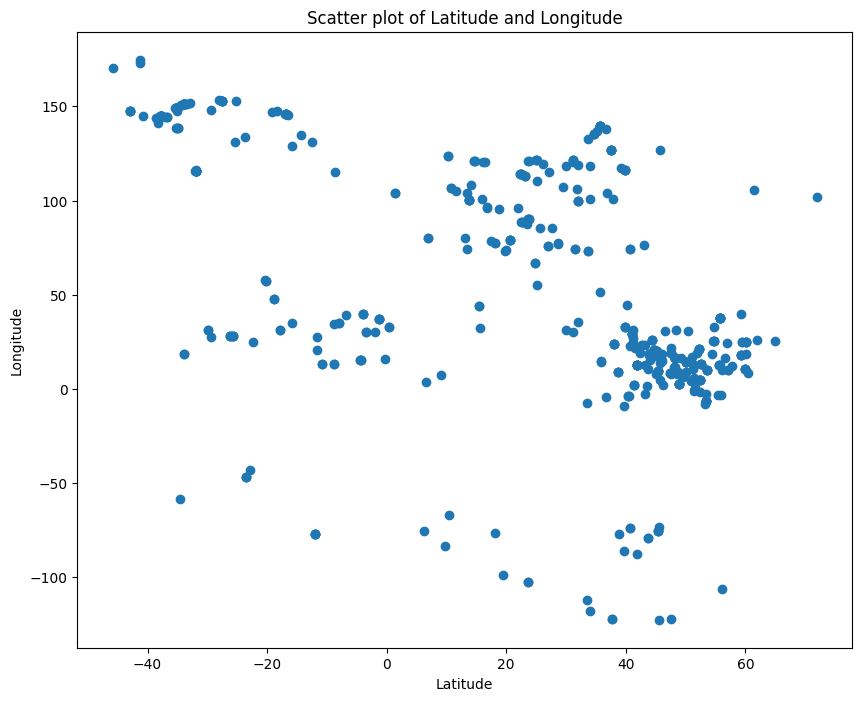

In [233]:
# Read the csv
df = pd.read_csv('data/city_locations.csv')
print(df.shape)

# Scatter plot for Latitude and Longitude
plt.figure(figsize=(10, 8))
plt.scatter(df['Latitude'], df['Longitude'])
plt.title('Scatter plot of Latitude and Longitude')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In [234]:
# Add a new column isAsia
df['isAsia'] = df['Continent'].apply(lambda x: 1 if x == 'Asia' else 0)
# Add a column for random number as dummy feature
df['Random_1'] = np.random.rand(len(df))

# Separate into training, validation, and test dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# print the datasets
print("Training dataset:")
print(train_df.head())
print(train_df['isAsia'].value_counts())
print("\nValidation dataset:")
print(val_df['isAsia'].value_counts())
print("\nTest dataset:")
print(test_df['isAsia'].value_counts())

Training dataset:
      Latitude   Longitude                                      CityName  \
256  -4.441931   15.266293                                      Kinshasa   
45   52.368000    4.903600                                     Amsterdam   
387 -40.822600  145.035900   Cradle Mountain-Lake St Clair National Park   
293  19.997500   73.789800                                        Mumbai   
149  43.856300   18.413100                                      Sarajevo   

      Continent  isAsia  Random_1  
256      Africa       0  0.667450  
45       Europe       0  0.446078  
387   Australia       0  0.293584  
293        Asia       1  0.630726  
149      Europe       0  0.578315  
isAsia
0    246
1     66
Name: count, dtype: int64

Validation dataset:
isAsia
0    77
1    27
Name: count, dtype: int64

Test dataset:
isAsia
0    76
1    29
Name: count, dtype: int64


In [235]:
# Prepare train, val, test datasets for features and truth labels
all_features = ['Latitude', 'Longitude', 'Random_1']

X_train = train_df[all_features].to_numpy()
Y_train = train_df['isAsia'].to_numpy()
X_train = X_train.astype('float32')
X_val = val_df[all_features].to_numpy()
X_val = X_val.astype('float32')
Y_val = val_df['isAsia'].to_numpy()
X_test = test_df[all_features].to_numpy()
X_test = X_test.astype('float32')
Y_test = test_df['isAsia'].to_numpy()

In [238]:
pos_df.min()

Latitude      -8.6704
Longitude     28.9784
CityName       Ankara
Continent        Asia
isAsia              1
Random_1     0.032634
dtype: object

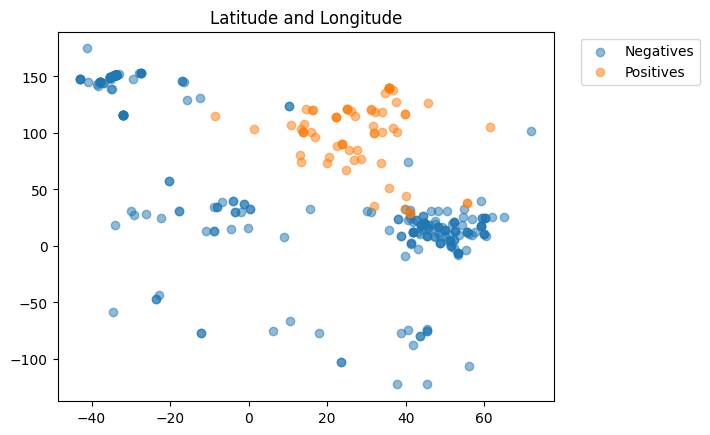

In [237]:
# Plotting model predictions on the original test dataset
neg_df = train_df[(train_df['isAsia']==0)]
pos_df = train_df[(train_df['isAsia']==1)]

plt.scatter(neg_df['Latitude'], neg_df['Longitude'], label="Negatives", alpha=0.5)
plt.scatter(pos_df['Latitude'], pos_df['Longitude'], label="Positives", alpha=0.5)
plt.title('Latitude and Longitude')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

## Build model

In [129]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.Accuracy(name='accuracy'),
    keras.metrics.BinaryAccuracy(name='binary_accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc')
]

In [130]:
# Weighted binary crossentropy is used for the imbalanced data training

class WeightedBinaryCrossEntropy(tf.keras.losses.Loss):
    def __init__(self, ratio: float):
        """
        Args:
            ratio (float): the multiplier of positive examples weights over negative examples
        """
        
        super().__init__()
        self.ratio = ratio
        
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        ratio = tf.convert_to_tensor(self.ratio, dtype=tf.float32)
        weights = (y_true * ratio) + tf.convert_to_tensor(1., dtype=tf.float32)
        
        bce = K.binary_crossentropy(y_true, y_pred)
        weighted_bce = K.mean(bce * weights)
        return weighted_bce

In [203]:
# Build a simple neural network model

INPUT_COLS = len(X_train[0])

input_shape = (None, INPUT_COLS)

model = Sequential()
model.add(Flatten())
model.add(Dense(16, 
                 activation='relu',
                 input_shape=input_shape,
               ))
model.add(Dense(8, 
                 activation='relu',
               ))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
# initialize optimizer
model.compile(optimizer='Adam',
              loss=WeightedBinaryCrossEntropy(ratio=2.0),
              metrics=[METRICS])

In [204]:
# Train model

EPOCHS = 300

history = model.fit(X_train, Y_train, batch_size=32, epochs=EPOCHS, validation_data=(X_val, Y_val))


Epoch 1/300
10/10 [==============================] - 2s 72ms/step - loss: 40.4905 - tp: 39.0000 - fp: 89.0000 - tn: 233.0000 - fn: 55.0000 - accuracy: 0.1010 - binary_accuracy: 0.6538 - precision: 0.3047 - recall: 0.4149 - auc: 0.5466 - val_loss: 23.5547 - val_tp: 0.0000e+00 - val_fp: 10.0000 - val_tn: 67.0000 - val_fn: 27.0000 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.6442 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4091
Epoch 2/300
10/10 [==============================] - 0s 21ms/step - loss: 39.2143 - tp: 26.0000 - fp: 84.0000 - tn: 161.0000 - fn: 41.0000 - accuracy: 0.1218 - binary_accuracy: 0.5994 - precision: 0.2364 - recall: 0.3881 - auc: 0.5087 - val_loss: 16.8647 - val_tp: 0.0000e+00 - val_fp: 11.0000 - val_tn: 66.0000 - val_fn: 27.0000 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.6346 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4091
Epoch 3/300
10/10 [==============================] - 0s 19ms/step - loss: 31.1783 - 

In [241]:
# See model summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 3)                 0         
                                                                 
 dense_25 (Dense)            (None, 16)                64        
                                                                 
 dense_26 (Dense)            (None, 8)                 136       
                                                                 
 dropout_8 (Dropout)         (None, 8)                 0         
                                                                 
 dense_27 (Dense)            (None, 1)                 9         
                                                                 
Total params: 209 (836.00 Byte)
Trainable params: 209 (836.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [240]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/sample_model')

INFO:tensorflow:Assets written to: saved_model/sample_model/assets


INFO:tensorflow:Assets written to: saved_model/sample_model/assets


In [75]:
def plot_graphs(history, string):
    """ Plot graphs on the model training history
    Args:
        history (keras.callbacks.History): output from the keras model after fitting
        string (str): The metrics for evaluation
    """
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

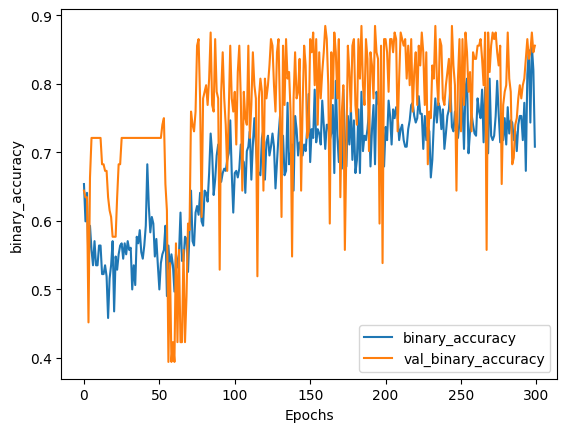

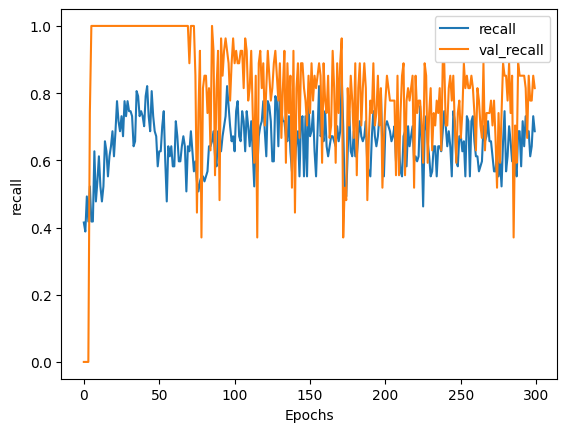

In [205]:
# Check model training history
plot_graphs(history, "binary_accuracy")
plot_graphs(history, "recall")

## Get model predictions

In [206]:
predictions = model.predict(X_test)
predicted_probabilities = [pred[0] for pred in predictions]
test_df['predicted_probability'] = predicted_probabilities
test_df["pred"] = (test_df["predicted_probability"] > 0.5).astype(int)

4/4 [==============================] - 0s 6ms/step


Text(0.5, 23.52222222222222, 'Model Prediction')

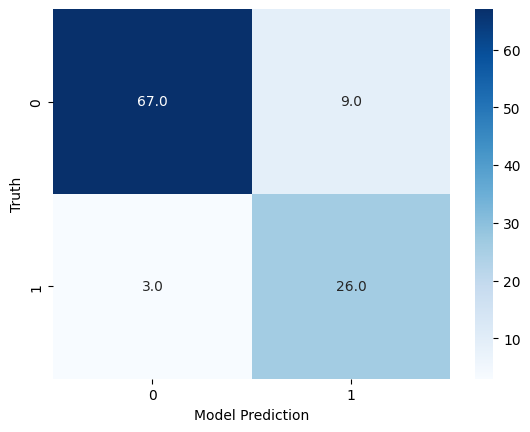

In [207]:
pred_table = test_df[['isAsia','pred', 'predicted_probability']]

# Accuracy matrix
y_true_label = pred_table['isAsia']
predict_valid_label = pred_table['pred']
proba_pred = pred_table['predicted_probability']

accuracy_matrix = confusion_matrix(y_true_label, predict_valid_label)

# Confusion Matrix Heatmap
acc_df = pd.DataFrame(accuracy_matrix)
ax = sns.heatmap(acc_df,  fmt=".1f",
         cmap='Blues',annot=True)
# X - Y axis labels
ax.set_ylabel('Truth')
ax.set_xlabel('Model Prediction')

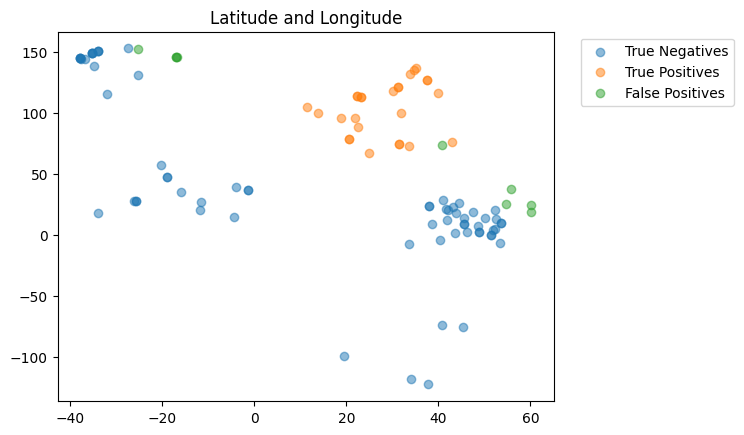

In [208]:
# Plotting model predictions on the original test dataset
fp_df = test_df[(test_df['isAsia']==0) & (test_df['pred']==1)]
tp_df = test_df[(test_df['isAsia']==1) & (test_df['pred']==1)]
tn_df = test_df[(test_df['isAsia']==0) & (test_df['pred']==0)]

plt.scatter(tn_df['Latitude'], tn_df['Longitude'], label="True Negatives", alpha=0.5)
plt.scatter(tp_df['Latitude'], tp_df['Longitude'], label="True Positives", alpha=0.5)
plt.scatter(fp_df['Latitude'], fp_df['Longitude'], label="False Positives", alpha=0.5)
plt.title('Latitude and Longitude')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

Now, we have a model trained on simulated imbalance data with very little false negatives. This is a typical situation in business as we apply ML in fields such as fraud detection, where truth labels are very limited but the cost of having any false negative is high.

## Typical use of Kernel Explainer

Kernel SHAP is a model agnostic algorithm - it applies to all the predictors. It is reliable and easy to use, however, the computation can be slow when the baseline dataset is huge. Using a sample/ the entire of the training data as the baseline is a common practice, as it represents a general view of the data and we can compare the model prediction of some instances with the general data.

In [209]:
def get_predictions(current_predictor, data_ds):
    """Function to get predictions using a model predictor and data.
    Args:
        current_predictor (keras.engine.sequential.Sequential): the trained model ready for predicitons
        data_ds (dataframe): dataset for prediction
    """
    predictions = current_predictor.predict(data_ds)
    return np.array(predictions, dtype='float64')


def f(X):
    """Same notation as the above formula.
    f(X) is the model prediction on X
    Args:
        X (dataframe): data for prediction
    """
    return get_predictions(model, X)


# Sample predictions
f(X_test[:5])

1/1 [==============================] - 0s 14ms/step


array([[0.00674311],
       [0.02870133],
       [0.10450105],
       [0.51965588],
       [0.91282523]])

In [210]:
# Define background sample
# Use the whole train dataset as background
background_sample = train_df[all_features]
print(background_sample.shape)
background_sample.head()

(312, 3)


,Latitude,Longitude,Random_1
256,-4.441931,15.266293,0.375719
45,52.368000,4.903600,0.238231
387,-40.822600,145.035900,0.747596
293,19.997500,73.789800,0.229769
149,43.856300,18.413100,0.054545


In [211]:
# Make a SHAP Kernel Explainer
# The first argument is the function for f(X)
# The second argument is the background data for E(f(X))
kernel_explainer = KernelExplainer(
    f,
    background_sample.to_numpy(),
)

10/10 [==============================] - 0s 3ms/step


In [212]:
# Check expected value of the baseline predictions
print(f"The expected value of Kernel explainer with whole training dataset as baseline: {kernel_explainer.expected_value[0]}")

The expected value of Kernel explainer with whole training dataset as baseline: 0.3957941026170514


This expected value is consistent with our simulated data construction. We have an imbalnced dataset so if we pick any random observation we would expect the probability of it being an Asian country close to zero.

In [213]:
# Pick a positive sample to see the model explanations
sample = test_df[(test_df['isAsia'] == 1) & (test_df['pred'] == 1)][all_features].sample(1)
sample

,Latitude,Longitude,Random_1
501,31.2244,121.4758,0.435043


In [214]:
shap_values = kernel_explainer.shap_values(sample.to_numpy())

  0%|          | 0/1 [00:00<?, ?it/s]

59/59 [==============================] - 0s 1ms/step


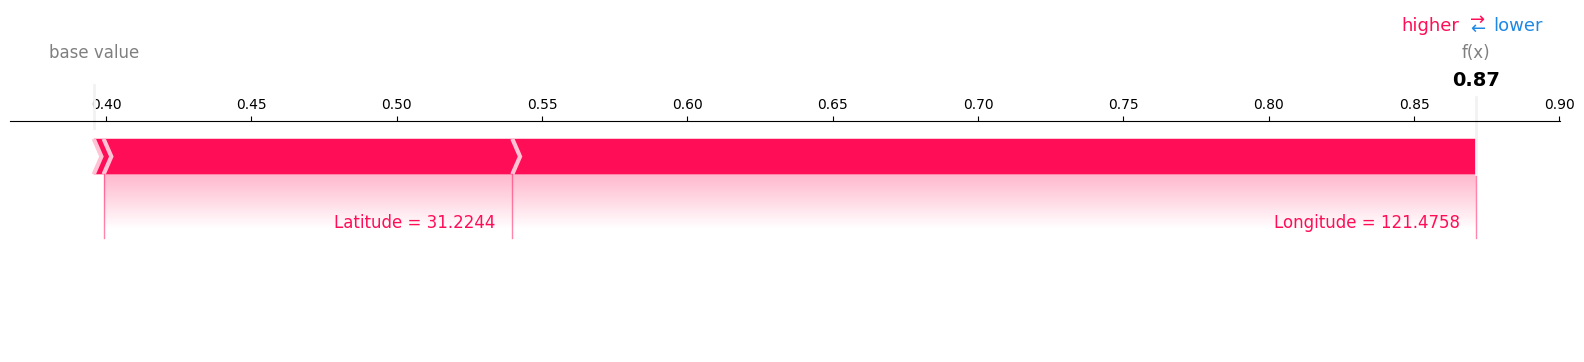

In [215]:
# Plot the shap values
shap.force_plot(kernel_explainer.expected_value, shap_values[0], sample, matplotlib=True)


In [216]:
# SHAP values 
pd.DataFrame(data=shap_values[0], columns=all_features)

,Latitude,Longitude,Random_1
0,0.140596,0.331606,0.003392


It looks like for this particular instance, the model finds Longitude more important than the Latitude in making its prediction. Let's further take a look at the Global SHAP.

## Global SHAP

In [217]:
def global_shap_plot(values, headers):
    """Function to plot Global SHAP
    Args:
        values (dataframe): SHAP values of all the data
        headers (str): Plot title
    """
    plt.rcdefaults()
    fig, ax = plt.subplots()
    y_pos = np.arange(len(headers))
    ax.barh(y_pos, values, align='center')
    ax.set_yticks(y_pos, labels=headers)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Global SHAP values')
    ax.set_title('Global SHAP Plot')

    plt.show()

In [218]:
start_time = time.time()
all_shap_values = kernel_explainer.shap_values(X_test)
end_time = time.time()
print(
    f"Computing SHAP for {X_test.shape[0]} records used time: {end_time - start_time} seconds"
)

  0%|          | 0/105 [00:00<?, ?it/s]

59/59 [==============================] - 0s 1ms/step
Computing SHAP for 105 records used time: 14.251112937927246 seconds


In [219]:
all_shaps_df = pd.DataFrame(data=all_shap_values[0], columns=all_features)
# Compute global SHAP: the mean of absolute values of local SHAP
global_shap = {}
for col in all_shaps_df.columns:
    global_shap[col] = all_shaps_df[col].abs().mean()
global_shap_df = pd.DataFrame(global_shap, index=[0])
global_shap_df

,Latitude,Longitude,Random_1
0,0.191647,0.232645,0.020294


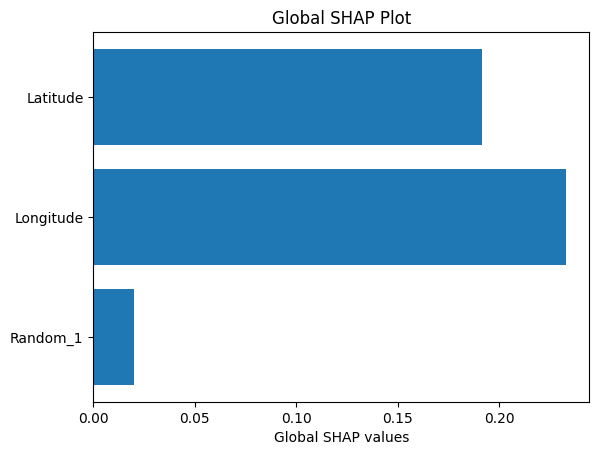

In [220]:
# Plot global SHAP
global_shap_plot(global_shap_df.iloc[0], global_shap_df.columns)

The Global SHAP tells us in general, the model finds Longitude having a much higher feature importance than Latitude (Latitude: 0.19; Longitude: 0.23). This is contradictory to our assumption as we would expect both Latitude and Longitude to be equally important in determining whether a city is in Asia. 

In the next section in this notebook I would explain why the SHAP value for Latitude was underestimated, and a possible resolution.

# Why the SHAP value for Latitude was underestimated?

Remember from the begining, we created an imbalanced dataset. 

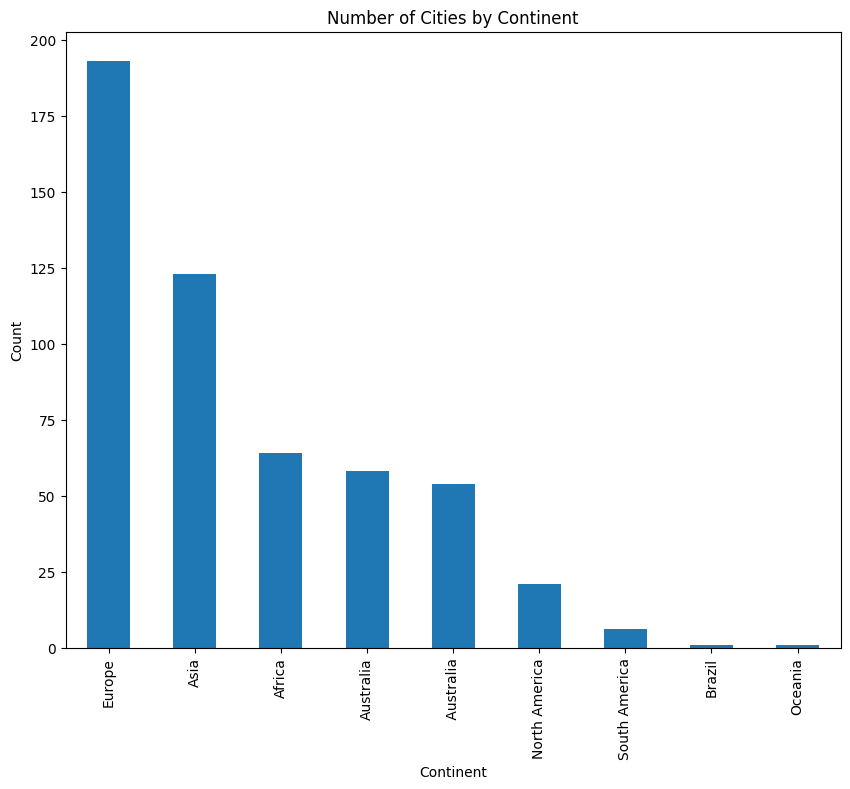

In [221]:
# Bar plot for count of cities by continent
# Make sure we have a simulated imbalanced dataset
continent_counts = df['Continent'].value_counts()
continent_counts.plot(kind='bar', figsize=(10, 8))
plt.title('Number of Cities by Continent')
plt.xlabel('Continent')
plt.ylabel('Count')
plt.show()

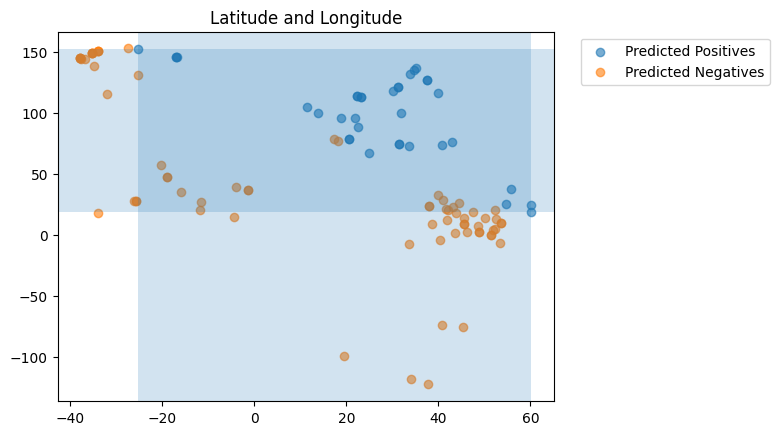

In [222]:
# Check the distribution of model predictions

new_pos_df = test_df[test_df['pred']==1]
new_neg_df = test_df[test_df['pred']==0]


plt.scatter(new_pos_df['Latitude'], new_pos_df['Longitude'], label="Predicted Positives", alpha=0.6)
plt.scatter(new_neg_df['Latitude'], new_neg_df['Longitude'], label="Predicted Negatives", alpha=0.6)
plt.title('Latitude and Longitude')
plt.axvspan(new_pos_df['Latitude'].min(), new_pos_df['Latitude'].max(), alpha=0.2)
plt.axhspan(new_pos_df['Longitude'].min(), new_pos_df['Longitude'].max(), alpha=0.2)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

Now, we can see that a significant amount of negative labeled cities with latitude falls into the blue region, which is the rage of lattiude that the model would predict a higher probability of city being in Asia. 

Using the training dataset as the background for SHAP calculation would make a biased result as the latitudes from the background are already likely to be in Asia. If we think about the employers A, B, C example again, we would need to estimate what happens if we have employer A/ B/ C working alone. However, in a model prediction we cannot remove a feature entirely, so the estimation on the marginal contribution would rely on a background data that is truly "meaningless".

# Resolution: use a self-defined baseline

We can try to construct a self-defined baseline with Latitude and Longitude that are less meaningful. Let's try with North Pole (0, 0):

In [223]:
baseline = pd.DataFrame({
    'Latitude': [0, 90, 90, -90, -90],
    'Longitude': [0, 180, -180, 180, -180],
    'Random_1': [0, 0, 0, 0, 0]
})
baseline

,Latitude,Longitude,Random_1
0,0,0,0
1,90,180,0
2,90,-180,0
3,-90,180,0
4,-90,-180,0


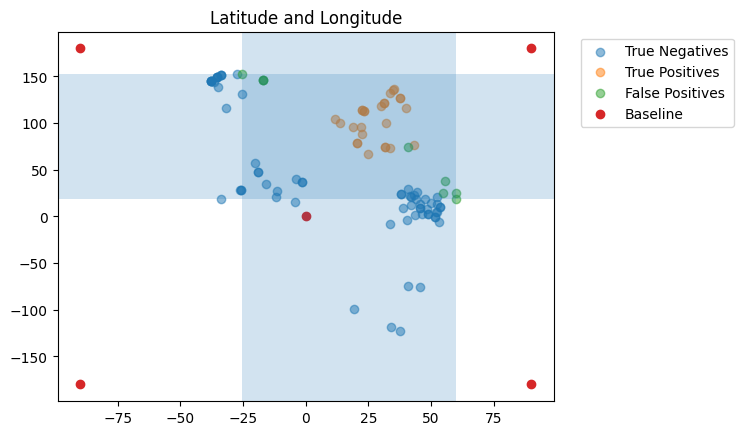

In [224]:
# Check the distribution of model predictions and baseline

fp_df = test_df[(test_df['isAsia'] == 0) & (test_df['pred'] == 1)]
tp_df = test_df[(test_df['isAsia'] == 1) & (test_df['pred'] == 1)]
tn_df = test_df[(test_df['isAsia'] == 0) & (test_df['pred'] == 0)]

plt.scatter(tn_df['Latitude'], tn_df['Longitude'],
            label="True Negatives", alpha=0.5)
plt.scatter(tp_df['Latitude'], tp_df['Longitude'],
            label="True Positives", alpha=0.5)
plt.scatter(fp_df['Latitude'], fp_df['Longitude'],
            label="False Positives", alpha=0.5)
plt.scatter(baseline['Latitude'], baseline['Longitude'],
            label="Baseline", alpha=1)
plt.axvspan(new_pos_df['Latitude'].min(),
            new_pos_df['Latitude'].max(), alpha=0.2)
plt.axhspan(new_pos_df['Longitude'].min(),
            new_pos_df['Longitude'].max(), alpha=0.2)
plt.title('Latitude and Longitude')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()


In [225]:
# Create a new SHAP Kernel Explainer
kernel_baseline_explainer = KernelExplainer(
    f,
    baseline.to_numpy(),
)

1/1 [==============================] - 0s 46ms/step


In [226]:
# Check expected value of the baseline predictions
print(
    f"The expected value of Kernel explainer with self-defined baseline: {kernel_baseline_explainer.expected_value[0]}")



The expected value of Kernel explainer with self-defined baseline: 0.22965437478892453


This time we used a self-defined basline that scatters evenly on the plane. The expected value is similar to the training dataset, which is expected.

In [227]:
# Check prediction on the sample
shap_baseline_values = kernel_baseline_explainer.shap_values(sample.to_numpy())


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


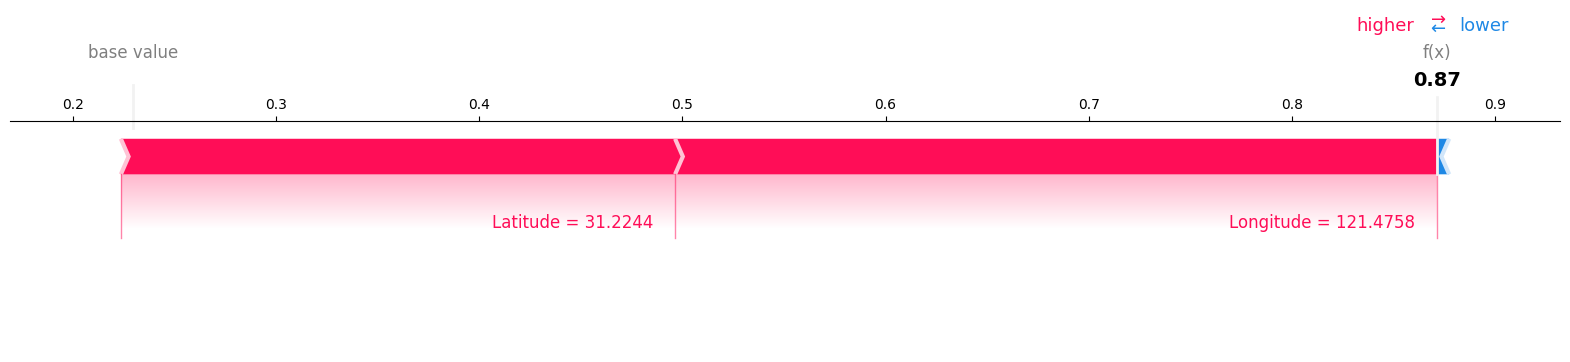

In [228]:
shap.force_plot(kernel_baseline_explainer.expected_value,
                shap_baseline_values[0], sample, matplotlib=True)


## Global SHAP

In [229]:
start_time = time.time()
all_baseline_shap_values = kernel_baseline_explainer.shap_values(X_test)
end_time = time.time()
print(
    f"Computing SHAP for {X_test.shape[0]} records used time: {end_time - start_time} seconds"
)

  0%|          | 0/105 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step
Computing SHAP for 105 records used time: 4.8622050285339355 seconds


In [230]:
all_baseline_shap_values_df = pd.DataFrame(data=all_baseline_shap_values[0], columns=all_features)
# Compute global SHAP: the mean of absolute values of local SHAP
global_shap = {}
for col in all_baseline_shap_values_df.columns:
    global_shap[col] = all_baseline_shap_values_df[col].abs().mean()
global_shap_df = pd.DataFrame(global_shap, index=[0])
global_shap_df

,Latitude,Longitude,Random_1
0,0.141414,0.160658,0.010788


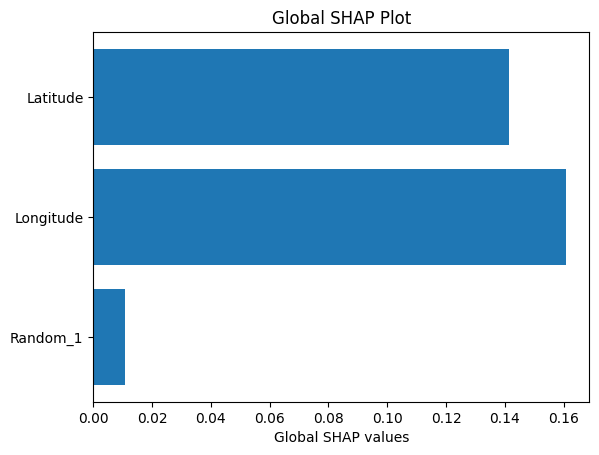

In [231]:
# Plot global SHAP
global_shap_plot(global_shap_df.iloc[0], global_shap_df.columns)

Now, we got the SHAP values for Latitude and Longitude similar to each other (Latitude: 0.14; Longitude: 0.16). This is because the SHAP computation is comparing with a "meaningless" baseline, so the marginal contribution from the two features would be equally high. Also note that the runtime reduced significantly as there are less iterations in the SHAP computation.

# Conclusion

SHAP is a very useful computation to help us identify the feature importances and understand the model behavior. However, we should be careful in our interpretation on the results. Instead of simply saying "a high SHAP value indicates high feature importance", we should consider it as "the marginal contribution from the feature $x$ is high when comparing to its baseline values". Pay special attention to the imbalanced dataset as it may alter our interpretation on the SHAPs. We could produce a more reliable result with a self-defined "meaningless" baseline, and that would also have a better runtime than inputting the entire training dataset as the baseline. 